# Assignment 2 — Gaussian Filter

Course: Quantum Programming <br>
Author: Danis Alukaev <br>
Group: B19-DS-01 <br>
Email: d.alukaev@innopolis.university <br>

# [100 in total] Processing data vector on a Quantum Computer

In this homework we will learn a cool story about the data processing. Your task may sounds very simple - you will apply Gaussian filtering to the plain vector of 16 numbers. (This task can be generalized to an image if we recall that $G_{xy} = G_{x}\circ G_{y}$, but here we care only about the vector).

## Gaussian filter as a matrix multiplication

Of course, before we do it on a quantum computer, let us first model this computation in a matrix form.

Gaussian blur is a _convolution_ operation, which is different from just a multiplication.
Convolutions are applied within data windows, not for the whole data vector. In a matrix form it will be a collection of the kernel vectors with the shifts. These shifts define "convolution windows".

### Get the kernel
Our first step is to construct a vector kernel, let it be a $5\times 1$:

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

kernel = np.array([norm.pdf(i) for i in range(-2, 3)])

# kernel should have the sum of 1, which means it should not make the image darker or lighter on total
kernel = kernel / sum(kernel)
print(kernel)

[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]


Let us now generate the data for the test and compute the blur:

<BarContainer object of 16 artists>

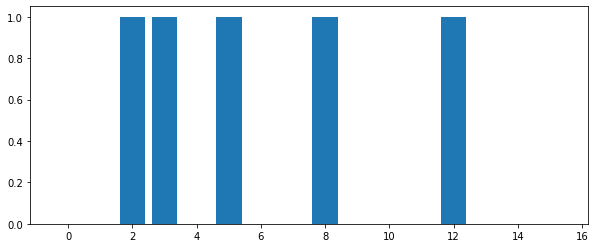

In [2]:
data = np.array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
plt.figure(figsize=(10, 4))
plt.bar(range(16), data)

<BarContainer object of 16 artists>

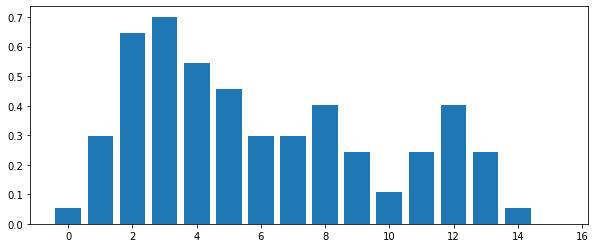

In [3]:
blurred_with_convolution = np.convolve(data, kernel, mode='same')
plt.figure(figsize=(10, 4))
plt.bar(range(16), blurred_with_convolution)

Note that the peaks are on the same places, but in-between positions have also obtained their amplitudes.

### Get the matrix

Here I construct (yep, looks like a hack) a matrix which performs exactly the same convolution by multiplication.

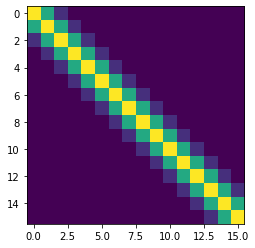

In [4]:
G = np.zeros((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    start = i - kernel.shape[0] // 2
    end = i + kernel.shape[0] // 2
    kerneloffset = 0 if start >= 0 else -start
    kernelendoffset = 0 \
                if end < data.shape[0] \
                else  end - data.shape[0] + 1
    G[start + kerneloffset:end - kernelendoffset + 1, i] = kernel[kerneloffset:len(kernel)-kernelendoffset]
    
plt.imshow(G)

<BarContainer object of 16 artists>

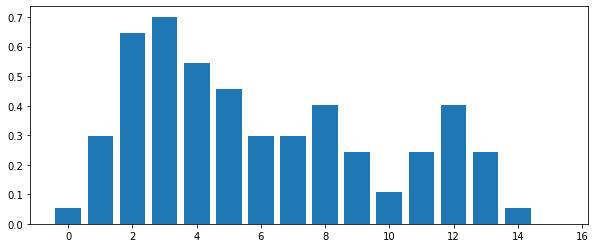

In [5]:
blurred_with_matrix = G @ data

# check results are the same!
assert np.allclose(blurred_with_convolution, blurred_with_matrix)
plt.figure(figsize=(10, 4))
plt.bar(range(16), blurred_with_convolution)

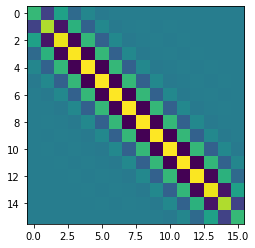

In [6]:
# we are happy that G is a reversible operation!
unG = np.linalg.inv(G)
assert np.allclose(unG @ G, np.eye(G.shape[0]))
plt.imshow(unG)

So we are almost ready to run this to the quantum vector... Wait... Is this unitary?! Oh noooo!

In [7]:
assert np.allclose(G.T.conj() @ G, np.eye(G.shape[0])), "The matrix G is not unitary!!!!1111"

AssertionError: ignored

## Unitary matrix construction

How do we construct a matrix $U$ which may be bigger, but still contains the desired transformation and is unitary?!

[This guy proposes multiple ways](https://youtu.be/d3f3JRo0WUo), we will follow the first one called "block encoding". [Listen for the solution intuition for a sec!](https://youtu.be/d3f3JRo0WUo?t=709) And take a look at the slide. The slide provides the direct instruction to finding such a matrix in the explicit form!

In quantum computing the idea is to dedicate additional "garbage" space in the state vector (padding with 0s) which will be affected by the rest of the matrix, and only care about the measurements which are from the desired half of the distribution.

As we keep the desired matrix in the corner, we:
- create an ancillary qubit, which is equivalent to padding a vector with zeros,
- measure,
- consider only those shots where ancilla remains in 0. This means that in the resulting superposition $|0_A\rangle A|\psi\rangle+|1_A\rangle|*\rangle$ we care about the left part of the distribution.

## [30] Block-encoding of a arbitrary matrix in Unitary

We will follow "impractical" way here. Your first task is to fill the matrix $U$ [according to the slide](https://www.youtube.com/watch?v=d3f3JRo0WUo&t=709s). Matrix names correspond.

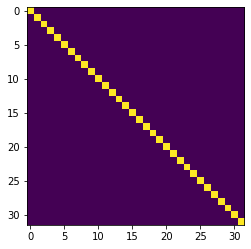

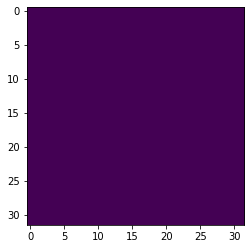

In [8]:
# I rescale G to have a norm less then 1, otherwise it will not be modelled properly
Gnorm = np.linalg.norm(G)
eps = 1e-6
A = G / (Gnorm + eps)

# TODO: create a desired unitary matrix U of twice as bigger size!
U = np.zeros(shape=list(d * 2 for d in A.shape), dtype=np.complex128)

# TODO: fill the matrix U according to the slide. Let me help to start:
h, w = A.shape[0], A.shape[1]
U[:h, :w] = A
U[h:, w:] = A

# note that * symbol on the slide corresponds to "transposed conjugate" or just "dagger"
# for the square matrix root you may use this function:
from scipy.linalg import sqrtm

# TODO assign the rest
I = np.identity(h, dtype=np.complex128)
As = A.T.conj() @ A
U[:h, w:] = - sqrtm(I - As)  # TODO
U[h:, :w] = sqrtm(I - As)  # TODO

# check that U(U^†) is identity.
plt.imshow((U @ U.T.conj()).real)        # real part
plt.show()
plt.imshow((-1j * U @ U.T.conj()).real)  # imaginary part

Does it do the job? Mess on the right, but needed picture on the left!

<BarContainer object of 32 artists>

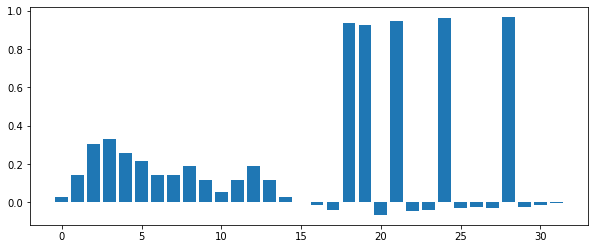

In [9]:
datapadded = np.zeros((data.shape[0] * 2))
datapadded[:len(data)] = data
plt.figure(figsize=(10, 4))

# HERE WE APPLY TRANSFORMATION
result = (U @ datapadded).real

plt.bar(range(len(datapadded)), result)

## So, what is next? Let us compose a circuit which is doing the same matrix multiplication.
### [10] Prepare the data
### [40] Construct a ciruit
Additional constraints here are:
1. We need to norm the vector (to make it a valid statevector).
2. We need to use ancilla (to pad the vector with 0s).

Data norm, should be exactly 1: 1.0


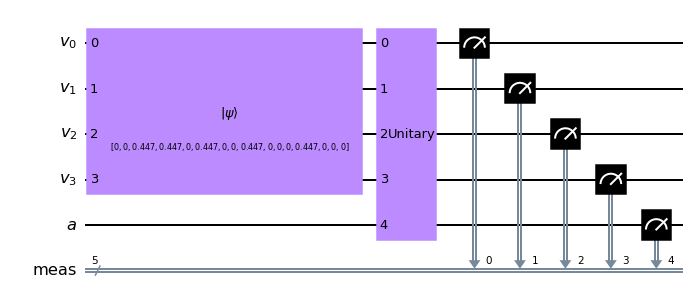

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator

qr = QuantumRegister(4, name="v")       # register for the data
qa = QuantumRegister(1, name="a")       # register for ancilla
cr = ClassicalRegister(5, name="meas")  # where we measure
qc = QuantumCircuit(qr, qa, cr)         # the circuit

# the operator should not change the sum. We will keep it for the last step.
data_sum = sum(data)

normed_data = data / np.linalg.norm(data)
data_norm = np.linalg.norm(normed_data) # TODO
print("Data norm, should be exactly 1:", data_norm)

# TODO your code to create a circuit comes here.
# 1. Initialize the state on 0-3 qr qubits.
qc.initialize(normed_data, qr[:])

# 2. Apply the transformation on qr[:] + qa[:]
qc.append(Operator(U), qr[:] + qa[:])

# 3. Measure all qubits.
qc.measure(qr[:] + qa[:], cr)

qc.draw('mpl')

In [11]:
qct = transpile(
    qc, 
    BasicAer.get_backend('qasm_simulator'), 
    basis_gates=['cx', 'x', 'y', 'z', 'rx', 'ry', 'rz', 'u3', 'u2', 'u1', 'h']
)

Just check how big the resulting program is!

In [12]:
qct.depth(), qct.count_ops()['cx']
# qct.draw('mpl')

(961, 514)

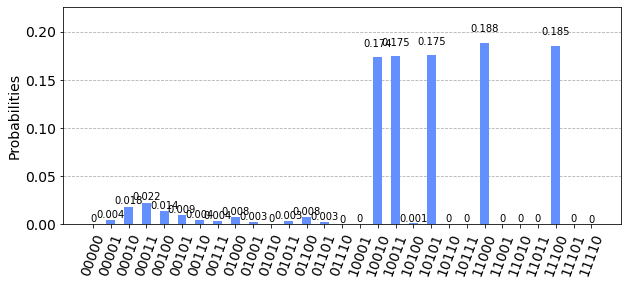

In [13]:
counts = execute(
    qc, 
    BasicAer.get_backend('qasm_simulator'), 
    shots=50000
).result().get_counts()
plot_histogram(counts, figsize=(10, 4))

## Postprocessing
Our data need cleaning!
1. It has unnecessary measurements where ancilla is 1.
2. The data are in the form of probabilities (basically counts), not amplitudes.
3. The data were scaled.

Let us unwind the computation:

### [10] Remove unnecessary shots from `counts` dict.

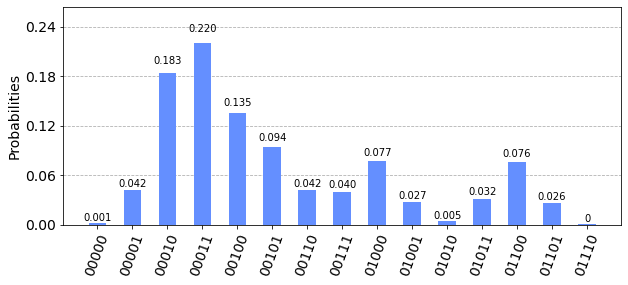

In [14]:
filtered_counts = {k: v for (k, v) in counts.items() if k[0] == '0'} # TODO
plot_histogram(filtered_counts, figsize=(10, 4))

### [10] Convert counts into amplitudes, and dict into the array.

First, retrieve probabilities from the count dict, and write them to the vector `probs`.

In [15]:
probs = np.zeros((data.shape[0]))
total_shots = 0

# TODO write PROBABILITIES to the corresponding vector positions
# HINT: you may use int(key, base=2)
for k, v in filtered_counts.items():
    probs[int(k, base=2)] = v
total_shots = np.sum(probs)
probs /= total_shots 

Second, convert PROBABILITIES into the AMPLITUDES.

<BarContainer object of 16 artists>

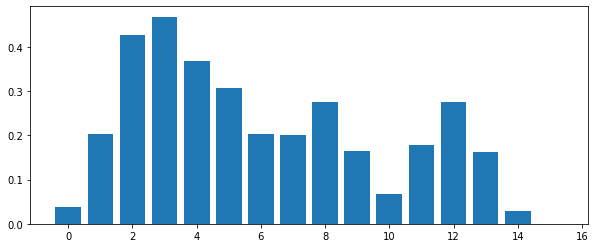

In [16]:
amplitudes = np.sqrt(probs) # TODO
plt.figure(figsize=(10, 4))
plt.bar(range(len(data)), amplitudes)

# Restore the data sum

<BarContainer object of 16 artists>

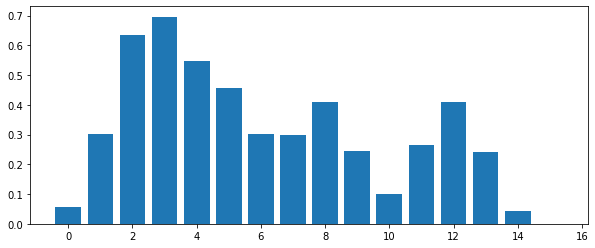

In [17]:
finally_data = amplitudes / sum(amplitudes) * data_sum
plt.figure(figsize=(10, 4))
plt.bar(range(len(data)), finally_data)